In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
!pip install scikit-opt
from sko.PSO import PSO
import numpy as np
from scipy.fft import dct

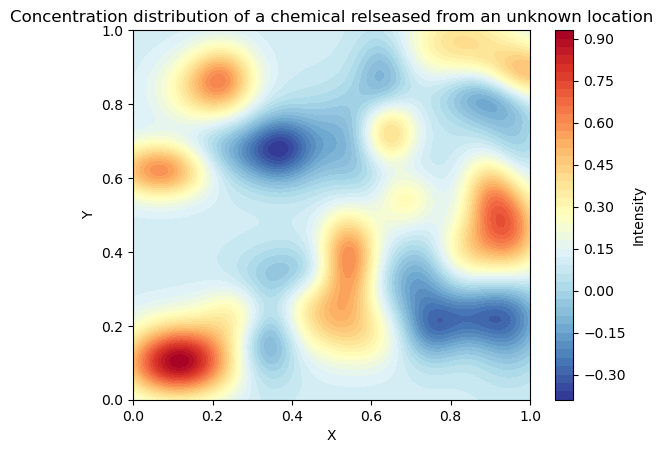

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数
def z_function(x, y):
    # 背景值
    z = 0.1 * np.ones_like( x)
    # 随机生成多个高斯峰值
    np.random.seed(13)  # 固定种子以便重现结果
    n_peaks = 30  # 增加峰值数量
    peaks = []
    for _ in range(n_peaks):
        peak = {
            'A': np.random.uniform(0.2, 0.6) if np.random.random() > 0.3 else -np.random.uniform(0.2, 0.4),  # 减小幅度范围
            'x0': np.random.uniform(0, 1),
            'y0': np.random.uniform(0, 1),
            'sigma_x': np.random.uniform(0.05, 0.1),  # 减小扩散系数范围
            'sigma_y': np.random.uniform(0.05, 0.1)   # 减小扩散系数范围
        }
        peaks.append(peak)
    
    for peak in peaks:
        A, x0, y0, sigma_x, sigma_y = peak.values()
        z += A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))
    return z

# 生成网格
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
Z = z_function(X, Y)

# 可视化
plt.contourf(X, Y, Z, cmap='RdYlBu_r', levels=50)
plt.colorbar(label='Intensity')
plt.title('Concentration distribution of a chemical relseased from an unknown location')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# 取样 9x9

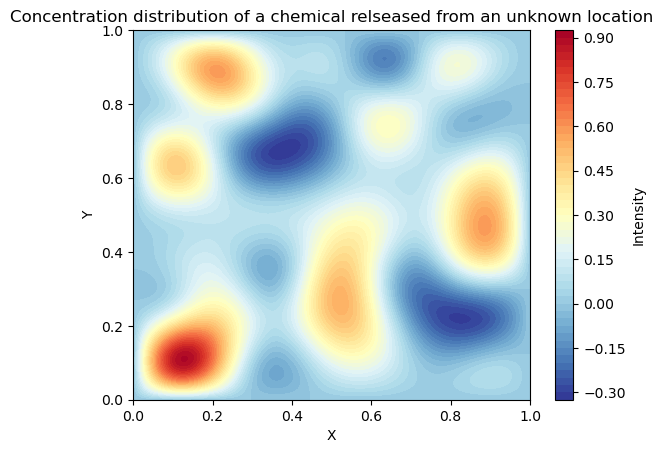

In [6]:
# 生成 9x9 离散点
nx, ny = 9, 9
x_points = np.linspace(0, 1, nx)
y_points = np.linspace(0, 1, ny)
X_grid, Y_grid = np.meshgrid(x_points, y_points)
Lx, Ly = 1, 1 # 定义网格大小
# 计算函数值 (Rosenbrock 函数)
Z_original = z_function(X_grid, Y_grid)

# 计算 2D Fourier sine series coefficients
def compute_2d_fourier_sine_coeffs(Z, nx, ny):
    M, N = nx - 1, ny - 1  # Maximum indices for m, n (up to 8)
    b_mn = np.zeros((M, N))
    
    for m in range(1, M + 1):
        for n in range(1, N + 1):
            integrand = Z * np.sin(m * np.pi * X_grid / Lx) * np.sin(n * np.pi * Y_grid / Ly)
            b_mn[m-1, n-1] = (4 / (M * N)) * np.sum(integrand)  
    return b_mn 

# 计算系数
b_mn = compute_2d_fourier_sine_coeffs(Z_original, nx, ny)   
# 重构 2D Fourier sine series at the 9x9 points
Z_fourier = np.zeros((len(X), len(Y)))
for m in range(1, nx):
    for n in range(1, ny):
        Z_fourier += b_mn[m-1, n-1] * np.sin(m * np.pi * X / Lx) * np.sin(n * np.pi * Y / Ly)

# 可视化    
plt.contourf(X, Y, Z_fourier, cmap='RdYlBu_r', levels=50)
plt.colorbar(label='Intensity')
plt.title('Concentration distribution of a chemical relseased from an unknown location')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


# DCT with normalization

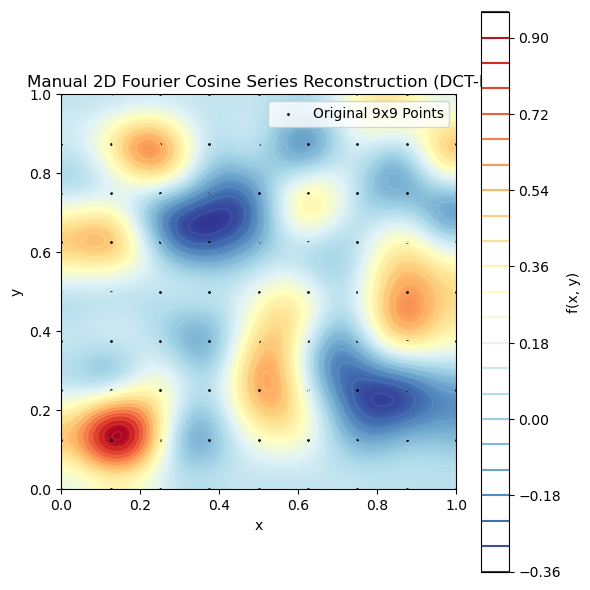

In [8]:
# 设置参数
Nx, Ny = 9, 9  # DCT-I 系数的网格大小
Lx, Ly = 1, 1
# 1. 创建 2D 网格 & 随机函数值
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

Z = z_function(X, Y)  # 注意 shape 为 (Ny, Nx)

# 2. 归一化 x 和 y 坐标（用于高分辨率计算）
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

# 3. 执行 DCT-I（先按 y 方向，再按 x）
Z_dct = dct(dct(Z.T, type=1, norm=None).T, type=1, norm=None)

# 4. 手动高分辨率重建函数
def dct2_reconstruct(xh, yh, a, Nx, Ny):
    """
    使用 DCT-I 系数手动重建 f(x, y)，xh 和 yh 是归一化 [0, 1] 的高分辨率网格。
    a 是 DCT-I 系数，形状为 (Ny, Nx)
    """
    Z_rec = np.zeros_like(xh)
    for m in range(Nx):
        for n in range(Ny):
            coef = a[n, m]  # 注意索引顺序与 numpy shape 对应
            if m == 0 or m == Nx - 1:
                coef /= 2
            if n == 0 or n == Ny - 1:
                coef /= 2
            Z_rec += coef * np.cos(m * np.pi * xh) * np.cos(n * np.pi * yh)
    Z_rec /= (Nx - 1) * (Ny - 1)
    return Z_rec

# 5. 高分辨率网格
x_hr = np.linspace(0, Lx, 200)
y_hr = np.linspace(0, Ly, 200)
X_hr, Y_hr = np.meshgrid(x_hr, y_hr)

# 归一化高分辨率坐标
Xn_hr = (X_hr - x_min) / (x_max - x_min)
Yn_hr = (Y_hr - y_min) / (y_max - y_min)

# 重建高分辨率图像
Z_hr = dct2_reconstruct(Xn_hr, Yn_hr, Z_dct, Nx, Ny)

# 6. 可视化
plt.figure(figsize=(6, 6))
plt.imshow(Z_hr, extent=[0, Lx, 0, Ly], origin='lower',
           cmap='RdYlBu_r', aspect='equal')
plt.contour(X_hr, Y_hr, Z_hr, levels=20, cmap='RdYlBu_r', alpha=1)
plt.colorbar(label='f(x, y)')
plt.scatter(X, Y, c='black', s=1, label=f'Original {Nx}x{Nx} Points')
plt.title('Manual 2D Fourier Cosine Series Reconstruction (DCT-I)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()


# PSO


In [180]:
# 设置迭代次数
max_iter = 50


# 定义 Rosenbrock 目标函数
def plumechasing(pos):
    # 确保 pos 是正确的形状 (n_particles, 2)
    x, y = pos
    X, Y = np.meshgrid(x, y)
    Z_fourier = np.zeros((len(X), len(Y)))
    for m in range(1, nx):
        for n in range(1, ny):
            Z_fourier += b_mn[m-1, n-1] * np.sin(m * np.pi * X / Lx) * np.sin(n * np.pi * Y / Ly)

    return -Z_fourier

# 初始化 PSO
pso = PSO(func=plumechasing, n_dim=2, pop=10, max_iter=max_iter,
          lb=[0, 0], ub=[1, 1],w=0.7, c1=1, c2=1)

pso.record_mode = True
pso.run()



(array([0.12899735, 0.11041918]), array([-0.90369094]))

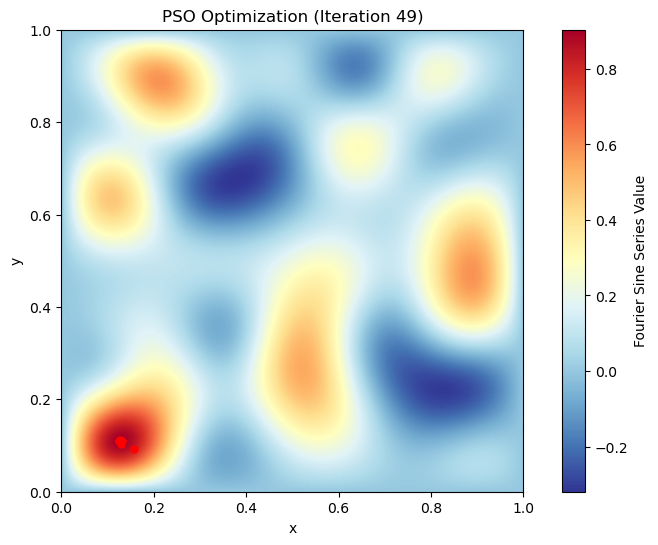

In [181]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('PSO Optimization on Rosenbrock Function over Fourier Background', loc='center')

# 使用 imshow 创建颜色渐变图 as the background
im = ax.imshow(Z_fourier, cmap='RdYlBu_r', extent=[0, 1, 0, 1], interpolation='bilinear', aspect='equal', origin='lower')
plt.colorbar(im, ax=ax, label='Fourier Sine Series Value')

# 设置轴标签
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('PSO Optimization over 2D Fourier Sine Series')

# 移除坐标轴边框
ax.set_facecolor('black')

# Initialize scatter plot for particles
line, = ax.plot([], [], 'r.', markersize=10, label='PSO Particles')

# Set axis limits (match imshow extent)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
# Enable interactive mode
plt.ion()

# Animation update function
def update_scatter(frame):
    i, j = frame // 10, frame % 10
    ax.set_title(f'PSO Optimization (Iteration {i})')
    
    X_list = pso.record_value['X']
    V_list = pso.record_value['V']
    # Get particle positions for iteration i, interpolated
    X_tmp = X_list[i] + V_list[i] * j / 10.0  # Interpolate using velocity
    X_tmp = X_tmp.reshape(-1, 2)  # Reshape to (pop, 2) for x, y pairs
    
    # Update scatter plot with 2D positions
    plt.setp(line, 'xdata', X_tmp[:, 0], 'ydata', X_tmp[:, 1])
    
    return line,

# Create animation
ani = FuncAnimation(fig, update_scatter, blit=True, interval=25, frames=max_iter * 10)

# Save animation as GIF
ani.save('PlumeChasing_N=9x9.gif', writer='pillow')

# Show plot
plt.show()
